In [1]:
from dmp.data.pmlb import pmlb_loader
import dmp.task.aspect_test.aspect_test_utils as aspect_test_utils
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from pmlb import fetch_data
from tensorflow import keras
import tensorflow as tf
import sys
%load_ext autoreload
%autoreload
# https://proceedings.neurips.cc/paper/2020/file/fdbe012e2e11314b96402b32c0df26b7-Paper.pdf
# http://proceedings.mlr.press/v48/wei16.pdf

sys.path.append("../../")


_datasets = pmlb_loader.load_dataset_index()


In [81]:
def make_model(dataset, widths, optimizer_config):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    model = keras.models.Sequential()
    model.add(tf.keras.Input(shape=inputs.shape[1:]))
    for width in widths:
        model.add(keras.layers.Dense(width, activation='relu',
                  kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(
        outputs.shape[1], activation=output_activation, kernel_initializer='glorot_normal'))

    optimizer = tf.keras.optimizers.get(optimizer_config)
    model.compile(optimizer=optimizer,
                  loss=run_loss,
                  #   loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', ],
                  )

    # print(model.summary())
    return model


def default_initializer(source_model, dest_model):
    for i, l in enumerate(source_model.layers):  # inserts old weights into new model
        old_width = l.output_shape[1]
        old_weights = l.get_weights()
        # new_weights = new_model.layers[i].get_weights()

        new_layer = dest_model.layers[i]
        new_weights = new_layer.get_weights()

        # new_weights[0] = new_weights[0] * 0
        # new_weights[1] = new_weights[1] * 0

        print(
            f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

        new_weights[0][:old_weights[0].shape[0],
                       :old_weights[0].shape[1]] = old_weights[0]
        new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
        new_layer.set_weights(new_weights)


def grow_network_replace(dataset, source_model, new_widths, optimizer_config, initializer=default_initializer):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    dest_model = keras.Sequential()
    input_shape = source_model.input_shape

    print(f'growing {len(source_model.layers)}')

    for i, l in enumerate(source_model.layers):  # adds modified layers to new model
        old_width = l.output_shape[1]
        new_width = new_widths[i] if len(new_widths) > i else old_width
        dest_model.add(keras.layers.Dense(
            new_width, activation=l.activation, kernel_initializer=l.kernel_initializer))

    dest_model.build(input_shape)  # makes new model (and initialized weights)

    initializer(source_model, dest_model)

    optimizer = tf.keras.optimizers.get(optimizer_config)
    dest_model.compile(optimizer=optimizer,
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])
    return dest_model


def plot_histories(configs, metric_trace, size_trace, x_axis_trace, colors=None):
    if colors is None:
        colors = cm.get_cmap('tab10').colors

    sequence_number = 0

    def plot_sequence(x, y):
        nonlocal sequence_number
        plt.plot(x, y,
                 'o-',               markersize=2.5,
                 color=colors[sequence_number % len(colors)],
                 alpha=.8,
                 linewidth=1.0,
                 )
        sequence_number += 1

    start = 0
    for i, s in enumerate(size_trace):
        if i > 0 and size_trace[i-1] != s:
            plot_sequence(x_axis_trace[start:i], metric_trace[start:i])
            start = i
    plot_sequence(x_axis_trace[start:], metric_trace[start:])


def plot_effort(configs, trace, metric='val_loss', colors=None):
    plot_histories(configs, trace[metric],
                   trace['size'], trace['effort'], colors=colors)


def plot_epoch(configs, trace, metric='val_loss', colors=None):
    plot_histories(configs, trace[metric],
                   trace['size'], trace['epoch'], colors=colors)


def plot_delta_efficiency(configs, trace, metric='loss', colors=None):
    plot_histories(configs, -np.diff(trace[metric], 1) / trace['size']
                   [1:], trace['size'][1:], trace['effort'][1:], colors=colors)


def plot_improvement(configs, trace, metric='loss', colors=None):
    plot_histories(configs, -np.diff(trace[metric], 1),
                   trace['size'][1:], trace['effort'][1:], colors=colors)


In [82]:
from typing import Iterable


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


def make_scaling_initializer(scale=.1):
    def initialize(source_model, dest_model):
        # inserts old weights into new model
        for i, l in enumerate(source_model.layers):
            old_width = l.output_shape[1]
            old_weights = l.get_weights()

            new_layer = dest_model.layers[i]
            new_weights = new_layer.get_weights()

            old_std = np.std(np.fromiter(flatten(old_weights), dtype=float))
            new_std = np.std(np.fromiter(flatten(new_weights), dtype=float))
            adjustment = scale * (old_std / new_std)
            new_weights[0] *= adjustment
            new_weights[1] *= adjustment

            # new_weights[0] = new_weights[0] * 0
            # new_weights[1] = new_weights[1] * 0

            print(
                f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

            new_weights[0][:old_weights[0].shape[0],
                           :old_weights[0].shape[1]] = old_weights[0]
            new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
            new_layer.set_weights(new_weights)
    return initialize


def make_cross_scaling_initializer(
    new_scale=None,  # scaling of new nodes
    cross_scale_in=None,  # scaling from old nodes to new nodes
    cross_scale_out=None,  # scaling from new nodes to old
    output_scale_out=None,  # scaling from new nodes to output nodes
    blend=0.0,
):
    def scale_block(
        source_population,
        dest_population,
        scale_setting,
        target_block,
    ):
        if scale_setting is None \
                or target_block.size <= 0 \
            or source_population.size <= 0 \
                or dest_population.size <= 0:
            return target_block

        source_std = np.std(np.fromiter(
            flatten(source_population), dtype=float))
        new_std = np.std(np.fromiter(flatten(dest_population), dtype=float))
        # if np.isnan(new_std) or np.isnan(source_std):
        #     print(f'Numerical error in setting adjustment {source_std} {new_std} {source_population.size} {dest_population.size}')
        #     return target_block
        # print(f'Numerical error in setting adjustment {source_std} {new_std} {scale_setting} {source_population.size} {dest_population.size}')
        adjustment = (scale_setting * source_std) / new_std
        return target_block * adjustment

    def initialize(source_model, dest_model):
        source_layers = list(source_model.layers)
        for i, (source_layer, dest_layer) in \
                enumerate(zip(source_layers, dest_model.layers)):

            source_weights, source_biases = source_layer.get_weights()
            dest_weights, dest_biases = dest_layer.get_weights()

            sw_shape = source_weights.shape
            sb_shape = source_biases.shape

            print(
                f'layer {i}, source shape: {(sw_shape, sb_shape)}, dest shape: {(dest_weights.shape, dest_biases.shape)}')

            csi = cross_scale_in if i > 1 else None
            cso = cross_scale_out if i < len(
                source_layers)-1 else output_scale_out

            src_in_idx = sw_shape[0]
            src_out_idx = sw_shape[1]

            # scale old to new nodes
            dest_weights[:src_in_idx, src_out_idx:] = \
                scale_block(
                source_weights,
                dest_weights[:src_in_idx, src_out_idx:],
                csi,
                dest_weights[:src_in_idx, src_out_idx:])

            # scale new to old nodes
            dest_weights[src_in_idx:, :src_out_idx] = \
                scale_block(
                source_weights,
                dest_weights[src_in_idx:, :src_out_idx],
                cso,
                dest_weights[src_in_idx:, :src_out_idx])

            # scale new nodes
            dest_weights[src_in_idx:, src_out_idx:] = \
                scale_block(
                source_weights,
                dest_weights[src_in_idx:, src_out_idx:],
                new_scale,
                dest_weights[src_in_idx:, src_out_idx:])

            # dest_biases[sb_shape[0]:] = \
            #     scale_block(
            #     source_biases,
            #     dest_biases[sb_shape[0]:],
            #     new_scale,
            #     dest_biases[sb_shape[0]:])

            dest_weights[:src_in_idx, :src_out_idx] = \
                source_weights * (1-blend) + \
                blend * dest_weights[:src_in_idx, :src_out_idx]
            dest_biases[:sb_shape[0]] = \
                source_biases * (1-blend) + \
                blend * dest_biases[:sb_shape[0]]

            dest_layer.set_weights((dest_weights, dest_biases))
    return initialize


'''
+ Use proper initializer for inter-segment weights
+ Scale inputs into old nodes so that the variance stays at a similar level
    + might reduce weights of old inputs to 'make room' for new inputs without increasing output variance
+ Scale outputs from old nodes to account for larger fan-out
+ overall, maybe re-scale to target sqrt(2) * sqrt(2/(fan_in + fan_out)) for ReLU, sqrt(2/(fan_in + fan_out)) for Sigmoid
+ previous initialization had some fan_in_old and fan_out_old with stddev s_old, new initialization could scale old weights by (s_new / s_old) = sqrt((fan_in_old + fan_out_old) / (fan_in_new + fan_out_new))
'''


"\n+ Use proper initializer for inter-segment weights\n+ Scale inputs into old nodes so that the variance stays at a similar level\n    + might reduce weights of old inputs to 'make room' for new inputs without increasing output variance\n+ Scale outputs from old nodes to account for larger fan-out\n+ overall, maybe re-scale to target sqrt(2) * sqrt(2/(fan_in + fan_out)) for ReLU, sqrt(2/(fan_in + fan_out)) for Sigmoid\n+ previous initialization had some fan_in_old and fan_out_old with stddev s_old, new initialization could scale old weights by (s_new / s_old) = sqrt((fan_in_old + fan_out_old) / (fan_in_new + fan_out_new))\n"

In [83]:
# X, y = fetch_data('mnist', return_X_y=True)
# X, y = fetch_data('sleep', return_X_y=True)

def load_dataset(name):
    dataset_series, inputs, outputs =  \
        pmlb_loader.load_dataset(_datasets, name)
    run_config = aspect_test_utils.prepare_dataset(
        'shuffled_train_test_split',
        .2,
        0.0,
        {},
        dataset_series['Task'],
        inputs,
        outputs,
    )

    train_inputs = run_config['x']
    train_outputs = run_config['y']
    test_inputs = run_config['validation_data'][0]
    test_outputs = run_config['validation_data'][1]

    num_inputs = inputs.shape[1:]
    num_outputs = outputs.shape[1]
    output_activation, run_loss = \
        aspect_test_utils.compute_network_configuration(
            num_outputs, dataset_series)
    dataset = (dataset_series, inputs, outputs, train_inputs, train_outputs,
               test_inputs, test_outputs, output_activation, run_loss)
    return dataset


In [88]:
def make_equal_epochs_growth_trigger(epoch_limit):
    def growth_trigger(model, epochs_at_stage, trace):
        return epochs_at_stage >= epoch_limit
    return growth_trigger


def make_scheduled_growth_trigger(schedule):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage
        if epochs_at_stage < schedule[stage]:
            return False
        stage += 1
        return True
    return growth_trigger


def make_improvement_growth_trigger(threhsold, final_stage, final_epochs):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage
        if stage < final_stage:
            loss_trace = trace['loss']
            if epochs_at_stage >= 1 and (loss_trace[-1] / loss_trace[-2]) > 1 - threhsold:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger


def make_efficiency_growth_trigger(min_efficiency, final_stage, final_epochs):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)
        loss_trace = trace['loss']
        if stage < final_stage:
            efficiency = (loss_trace[-2] - loss_trace[-1]) / size
            if epochs_at_stage > 1 and efficiency < min_efficiency:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger


def make_test_loss_growth_trigger(max_epochs, epoch_limit, threshold):
    num_epochs_above = 0
    num_epochs = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal num_epochs_above, num_epochs
        num_epochs += 1
        loss_trace = trace['val_loss']
        if num_epochs > 1:
            loss_delta = loss_trace[-1] - loss_trace[-2]
            if loss_delta > threshold:
                num_epochs_above += 1
            else:
                num_epochs_above = 0

        if num_epochs > max_epochs or num_epochs_above >= epoch_limit:
            num_epochs_above = 0
            num_epochs = 0
            return True
        return False
    return growth_trigger


def make_restoring_test_loss_growth_trigger(max_epochs, epoch_limit, threshold):
    num_epochs_above = 0
    num_epochs = 0
    weights_loss = None
    previous_weights = None

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal num_epochs_above, num_epochs, weights_loss, previous_weights
        num_epochs += 1
        loss_trace = trace['val_loss']

        loss = loss_trace[-1]

        if weights_loss is not None and loss - weights_loss >= threshold:
            num_epochs_above += 1
        else:
            num_epochs_above = 0

        if weights_loss is None or loss <= weights_loss:
            weights_loss = loss
            previous_weights = [layer.get_weights().copy()
                                for layer in model.layers]

        if num_epochs >= max_epochs or num_epochs_above >= epoch_limit:

            if previous_weights is not None:
                for layer, w in zip(model.layers, previous_weights):
                    layer.set_weights(w)

            num_epochs_above = 0
            num_epochs = 0
            weights_loss = None
            previous_weights = None
            return True

        return False
    return growth_trigger


def do_grow_train(configs, dataset, initializer, growth_trigger, optimizer_config):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    metrics = ['loss', 'val_loss']
    trace = {m: [] for m in metrics}
    trace['size'] = []
    trace['effort'] = []
    trace['epoch'] = []

    epoch = 0
    effort = 0
    model = None
    for i, widths in enumerate(configs):

        if model is None:
            model = make_model(dataset, widths, optimizer_config)
        else:
            model = grow_network_replace(
                dataset, model, widths, optimizer_config, initializer=initializer)
        print(model.summary())

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)
        trace['size'].append(size)

        trace['loss'].append(model.evaluate(train_inputs,
                                            train_outputs)[0])
        trace['val_loss'].append(
            model.evaluate(test_inputs, test_outputs)[0])
        trace['effort'].append(effort)
        trace['epoch'].append(epoch)

        # fit_result = model.fit(train_inputs, train_outputs, epochs = 10)
        # print(fit_result.history)
        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(test_inputs, test_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            for m in metrics:
                trace[m].append(fit_result.history[m][0])
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            if growth_trigger(model, epochs_at_stage, trace):
                break

    return model, trace


In [89]:

def make_model_of_size(
    inputs,
    target_size,
    make_widths,
    output_activation,
    layer_args,
):
    model_structure = \
        aspect_test_utils.find_best_layout_for_budget_and_depth(
            inputs,
            None,
            'relu',
            'relu',
            output_activation,
            target_size,
            make_widths,
            layer_args,
        )[2]

    return aspect_test_utils.make_keras_network_from_network_module(
        model_structure)


def make_averaging_ensemble_model(inputs, models):
    if len(models) == 1:
        return models[0]

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model(input) for model in models]
    output = tf.keras.layers.Average()(model_outputs)
    return tf.keras.Model(input, output)


def make_averaging_ensemble_of_size(
    inputs, source_model, target_size, make_widths,
    output_activation, layer_args,
):
    remaining_parameters = target_size
    if source_model is not None:
        source_parameters = \
            aspect_test_utils.count_parameters_in_keras_model(
                source_model)
        remaining_parameters = target_size - source_parameters
        source_model.trainable = False  # Freeze source model

    new_model = make_model_of_size(
        inputs,
        remaining_parameters,
        make_widths,
        output_activation,
        layer_args,
    )

    if source_model is None:
        return new_model, new_model

    ensemble_model = make_averaging_ensemble_model(
        inputs, [source_model, new_model])
    return ensemble_model, new_model


def do_train_freeze_grow(sizes, dataset, growth_trigger, make_widths, optimizer_config, freeze_old = True):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    layer_args = {'kernel_initializer': 'he_normal'}

    metrics = [
        'loss',
        'val_loss',
        'size',
        'effort',
        'free_effort',
        'epoch',
        'i_loss',
        'i_val_loss',
    ]
    trace = {m: [] for m in metrics}

    epoch = 0
    effort = 0
    free_effort = 0
    models = []
    model = None
    for i, size in enumerate(sizes):

        new_model = None
        remaining_parameters = size
        if model is not None:
            remaining_parameters -= \
                aspect_test_utils.count_parameters_in_keras_model(model)
                
        print(f'{remaining_parameters}/{size} paramters remaining for new model...')

        new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )
        models.append(new_model)
        model = make_averaging_ensemble_model(inputs, models)

        new_model_size = aspect_test_utils.count_parameters_in_keras_model(
            new_model)
        total_model_size = aspect_test_utils.count_parameters_in_keras_model(
            model)
        print(f'{new_model_size} parameters in new model -- total {total_model_size} vs {size} target, error {total_model_size - size}.')

        optimizer = tf.keras.optimizers.get(optimizer_config)

        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())
        if new_model != model:
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        print(model.summary())

        trace['size'].append(total_model_size)
        
        print('aggregate assesment...')
        trace['loss'].append(model.evaluate(train_inputs,
                                            train_outputs))
        trace['val_loss'].append(
            model.evaluate(test_inputs, test_outputs))

        print('individual assesment...')
        trace['i_loss'].append(new_model.evaluate(train_inputs,
                                                  train_outputs))
        trace['i_val_loss'].append(
            new_model.evaluate(test_inputs, test_outputs))

        trace['effort'].append(effort)
        trace['free_effort'].append(free_effort)
        trace['epoch'].append(epoch)

        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += total_model_size
            free_effort += new_model_size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(test_inputs, test_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            trace['loss'].append(fit_result.history['loss'][0])
            trace['val_loss'].append(fit_result.history['val_loss'][0])

            print('individual assesment...')
            trace['i_loss'].append(new_model.evaluate(train_inputs,
                                                      train_outputs))
            trace['i_val_loss'].append(
                new_model.evaluate(test_inputs, test_outputs))
                
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            trace['free_effort'].append(free_effort)

            if growth_trigger(model, epochs_at_stage, trace):
                break

        if freeze_old:
            new_model.trainable = False # freeze old models...

    return model, trace


In [90]:
def do_train_freeze_grow_separate(sizes, dataset, growth_trigger, make_widths, optimizer_config, freeze_old = True):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    layer_args = {'kernel_initializer': 'he_normal'}

    metrics = [
        'loss',
        'val_loss',
        'size',
        'effort',
        'total_effort',
        'epoch',
        'i_loss',
        'i_val_loss',
    ]
    trace = {m: [] for m in metrics}

    epoch = 0
    effort = 0
    total_effort = 0
    models = []
    model = None
    for i, size in enumerate(sizes):

        new_model = None
        remaining_parameters = size
        if model is not None:
            remaining_parameters -= \
                aspect_test_utils.count_parameters_in_keras_model(model)
                
        print(f'{remaining_parameters}/{size} paramters remaining for new model...')

        new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )
        models.append(new_model)
        model = make_averaging_ensemble_model(inputs, models)

        new_model_size = aspect_test_utils.count_parameters_in_keras_model(
            new_model)
        total_model_size = aspect_test_utils.count_parameters_in_keras_model(
            model)
        print(f'{new_model_size} parameters in new model -- total {total_model_size} vs {size} target, error {total_model_size - size}.')

        optimizer = tf.keras.optimizers.get(optimizer_config)
        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())
        if new_model != model:
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        print(model.summary())

        trace['size'].append(total_model_size)
        
        print('aggregate assesment...')
        trace['loss'].append(model.evaluate(train_inputs,
                                            train_outputs))
        trace['val_loss'].append(
            model.evaluate(test_inputs, test_outputs))

        print('individual assesment...')
        trace['i_loss'].append(new_model.evaluate(train_inputs,
                                                  train_outputs))
        trace['i_val_loss'].append(
            new_model.evaluate(test_inputs, test_outputs))

        trace['effort'].append(effort)
        trace['total_effort'].append(total_effort)
        trace['epoch'].append(epoch)

        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += new_model_size
            total_effort += total_model_size

            fit_result = new_model.fit(train_inputs, train_outputs,
                                   validation_data=(test_inputs, test_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            

            
            trace['i_loss'].append(fit_result.history['loss'][0])
            trace['i_val_loss'].append(fit_result.history['val_loss'][0])

            print('ensemble assesment...')
            trace['loss'].append(model.evaluate(train_inputs,
                                                      train_outputs))
            trace['val_loss'].append(
                model.evaluate(test_inputs, test_outputs))
                
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            trace['total_effort'].append(total_effort)

            if growth_trigger(model, epochs_at_stage, trace):
                break

        if freeze_old:
            new_model.trainable = False # freeze old models...

    return model, trace

    

In [7]:
dataset = load_dataset('sleep')

configs = [
    [16, 16, 16],
    [32, 32, 32],
    [64, 64, 64],
    [128, 128, 128],
]

adam_0_001 = {'class_name': 'adam', 'config': {'learning_rate': 0.0001}}

In [64]:
# full_configs = [([configs[-1][0], sum([c[1] for c in configs])])]

_, full_trace_128 = do_grow_train(
    [[128, 128, 128]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_32 = do_grow_train(
    [[32, 32, 32]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_64 = do_grow_train(
    [[64, 64, 64]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_16 = do_grow_train(
    [[16, 16, 16]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_96 = do_grow_train(
    [[96, 96, 96]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 128)               18176     
_________________________________________________________________
dense_219 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_220 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_221 (Dense)            (None, 5)                 645       
Total params: 51,845
Trainable params: 51,845
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 7s 3ms/step - loss: 0.7149 - accuracy: 0.7351 - val_loss: 0.6830 - val_accuracy: 0.7483
Epoch 2/2
2648/2648 [==============================] - 8s 3ms/step - loss: 0.6514 - accuracy: 0.7580 - val_los

In [94]:
adam_0_0001 = {'class_name': 'adam', 'config': {'learning_rate': 0.0001}}

_, full_trace_128_0_0001 = do_grow_train(
    [[128, 128, 128]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_0001,
)

_, full_trace_32_0_0001 = do_grow_train(
    [[32, 32, 32]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_0001,
)

_, full_trace_64_0_0001 = do_grow_train(
    [[64, 64, 64]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_0001,
)

_, full_trace_16_0_0001 = do_grow_train(
    [[16, 16, 16]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_0001,
)

_, full_trace_96_0_0001 = do_grow_train(
    [[96, 96, 96]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_0001,
)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 128)               18176     
_________________________________________________________________
dense_297 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_298 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_299 (Dense)            (None, 5)                 645       
Total params: 51,845
Trainable params: 51,845
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 8s 3ms/step - loss: 0.8322 - accuracy: 0.6950 - val_loss: 0.7229 - val_accuracy: 0.7348
Epoch 2/2
2648/2648 [==============================] - 7s 3ms/step - loss: 0.6997 - accuracy: 0.7417 - val_lo

In [95]:
# sizes = [
#     202,
#     405,
#     810,
#     1620,
#     3240,
#     6480,
#     12961,
#     25922,
#     51845,
# ]

sizes = [
    2901,
    6821,
    17733,
    32714,
    51845,
]

# _, fg_0 = do_train_freeze_grow(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_001,
#     )


_, fg_0_0_0001 = do_train_freeze_grow(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_0001,
    )


2901/2901 paramters remaining for new model...
2901 parameters in new model -- total 2901 vs 2901 target, error 0.
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_316 (Dense)            (None, 16)                2272      
_________________________________________________________________
dense_317 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_318 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_319 (Dense)            (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
ag

In [96]:
# _, fgs_0 = do_train_freeze_grow_separate(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_001,
#     )

_, fgs_0_0_0001 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_0001,
    )

    


2901/2901 paramters remaining for new model...
2901 parameters in new model -- total 2901 vs 2901 target, error 0.
Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_336 (Dense)            (None, 16)                2272      
_________________________________________________________________
dense_337 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_338 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_339 (Dense)            (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
ag

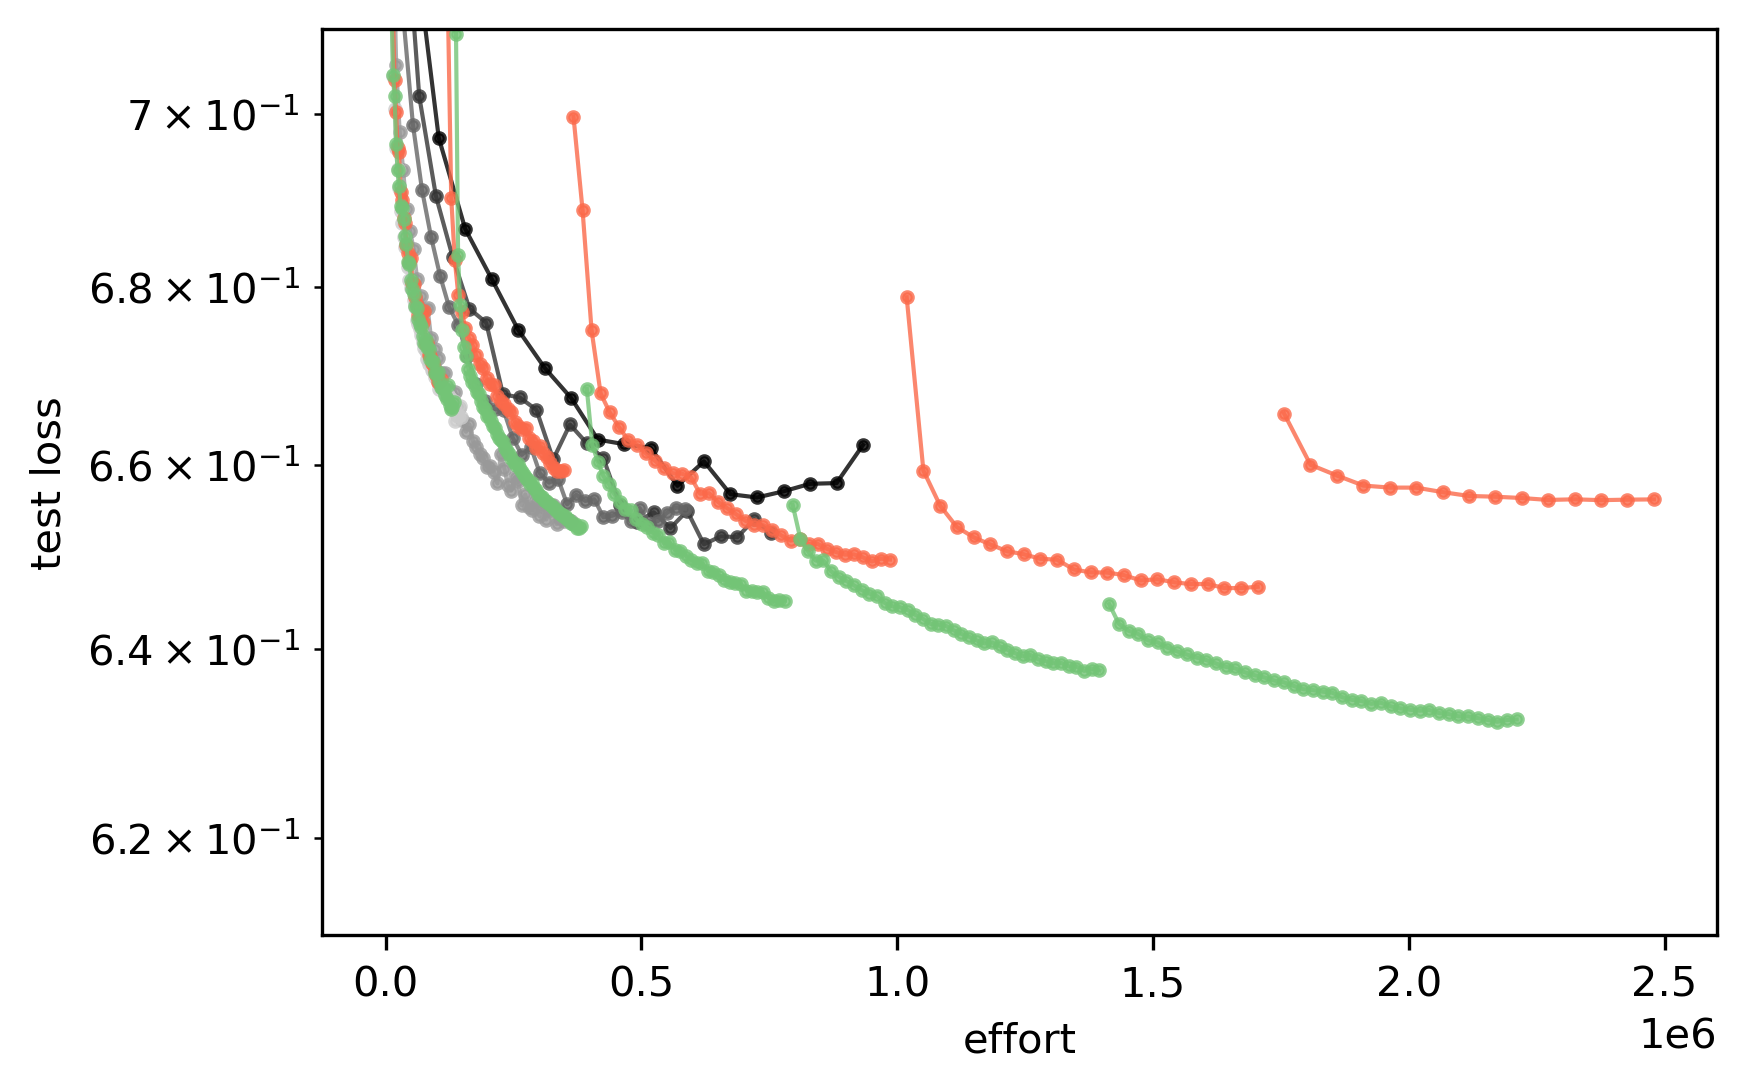

In [97]:
plt.figure(dpi=300)


# plot_effort(configs, full_trace_128, colors=[(0.0,0.0,0.0)])
# plot_effort(configs, full_trace_96, colors=[(0.2,0.2,0.2)])
# plot_effort(configs, full_trace_64, colors=[(0.4,0.4,0.4)])
# plot_effort(configs, full_trace_32, colors=[(0.6,0.6,0.6)])
# plot_effort(configs, full_trace_16, colors=[(0.8,0.8,0.8)])

# plot_effort(configs, fg_0, colors=cm.get_cmap('Reds')(np.linspace(.5, 1, 2)))
# plot_effort(configs, fgs_0, colors=cm.get_cmap('Greens')(np.linspace(.5, 1, 2)))

plot_effort(configs, full_trace_128_0_0001, colors=[(0.0,0.0,0.0)])
plot_effort(configs, full_trace_96_0_0001, colors=[(0.2,0.2,0.2)])
plot_effort(configs, full_trace_64_0_0001, colors=[(0.4,0.4,0.4)])
plot_effort(configs, full_trace_32_0_0001, colors=[(0.6,0.6,0.6)])
plot_effort(configs, full_trace_16_0_0001, colors=[(0.8,0.8,0.8)])

plot_effort(configs, fg_0_0_0001, colors=cm.get_cmap('Reds')(np.linspace(.5, 1, 2)))
plot_effort(configs, fgs_0_0_0001, colors=cm.get_cmap('Greens')(np.linspace(.5, 1, 2)))

# plot_effort(configs, fg_1, colors=cm.get_cmap('Reds')(np.linspace(.5, 1, 2)))
# plot_effort(configs, cross_N__N__0_01__0_01, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 2)))

# plot_effort(configs, cross_N__N__0_001__0_001, colors = cm.get_cmap('Blues')(np.linspace(.5,1, 2)))
# plot_effort(configs, cross_N__N__0_001__0_001__0_001, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
# plot_effort(configs, cross_N__N__0_0__0_1__0_0, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 2)))

# plot_effort(configs, cross_N__N__N__1, colors = cm.get_cmap('Greens')(np.linspace(.5,1, 2)))

# plot_effort(configs, test_loss_trigger_128__2__0_0__cross_scale_0_01_trace, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
# plot_effort(configs, test_loss_trigger_128__2__0_0__trace_0_1, colors = cm.get_cmap('Greens')(np.linspace(.5,1, 2)))
# plot_effort(configs, cross_scale_0_1__1_0_trace, colors = cm.get_cmap('Blues')(np.linspace(.5,1, 2)))
# plot_effort(configs, cross_scale_0_1__0_5_trace, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 2)))



plt.yscale('log')

# plt.xlim(300, 700e3)
plt.ylim(.61, .71)
plt.xlabel('effort')
plt.ylabel('test loss')


# plt.xlim(300, 3.01e3* 4)
# plt.ylim(.65, .72)

# plt.xlim(300, 60e3)
# plt.ylim(.65, .72)

# plt.xlim(100, 20e3)
# plt.ylim(.6, 1.5)

# plt.xlim(2e3, 20e3)
# plt.ylim(.65, 1.0)
# plt.xscale('log')
plt.show()


In [ ]:
_, cross_N__N__N__N = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=None,
                      output_scale_out=None,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # no scaling

# _, cross_N__0__N__N = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=0,
#                     cross_scale_out=None,
#                     output_scale_out=None,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # no inputs from old nodes to new nodes - reduces loss spike, limits loss

# _, cross_N__N__0__N = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=None,
#                     cross_scale_out=0,
#                     output_scale_out=None,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # no inputs from new nodes to old nodes - reduces loss spike, may slightly limit loss

# _, cross_N__N__N__1 = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=None,
#                     cross_scale_out=None,
#                     output_scale_out=1.0,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # outputs of new nodes are scaled to match old nodes  - no obvious effect, maybe worse spike


Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1151 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1152 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1153 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1154 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 9s 3ms/step - loss: 0.7768 - accuracy: 0.7094 - val_loss: 0.6976 - val_accuracy: 0.7438
Epoch 2/2
2648/2648 [==============================] - 9s 3ms/step - loss: 0.6859 - accuracy: 0.7458 - val_los

In [153]:
_, cross_N__0__0__0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=0,
                      cross_scale_out=0,
                      output_scale_out=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )        # should be same as not growing

_, cross_N__N__0__0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0,
                      output_scale_out=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )        # should be same as not growing


Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_955 (Dense)            (None, 16)                2272      
_________________________________________________________________
dense_956 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_957 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_958 (Dense)            (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 6s 2ms/step - loss: 0.7714 - accuracy: 0.7191 - val_loss: 0.6998 - val_accuracy: 0.7441
Epoch 2/2
2648/2648 [==============================] - 6s 2ms/step - loss: 0.6897 - accuracy: 0.7462 - val_los

In [185]:
_, cross_N__N__0_1__0_1 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.1,
                      output_scale_out=0.1,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale down outputs too?


Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1167 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1168 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1169 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1170 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 9s 3ms/step - loss: 0.7768 - accuracy: 0.7170 - val_loss: 0.6945 - val_accuracy: 0.7448
Epoch 2/2
2648/2648 [==============================] - 8s 3ms/step - loss: 0.6827 - accuracy: 0.7469 - val_los

In [186]:
_, cross_N__N__0_01__0_01 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.01,
                      output_scale_out=0.01,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1183 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1184 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1185 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1186 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 9s 3ms/step - loss: 0.7720 - accuracy: 0.7144 - val_loss: 0.6952 - val_accuracy: 0.7445
Epoch 2/2
2648/2648 [==============================] - 7s 3ms/step - loss: 0.6855 - accuracy: 0.7471 - val_los

In [187]:
_, cross_N__N__0_001__0_001 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.001,
                      output_scale_out=0.001,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


Model: "sequential_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1199 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1200 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1201 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1202 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 8s 3ms/step - loss: 0.7699 - accuracy: 0.7183 - val_loss: 0.6990 - val_accuracy: 0.7434
Epoch 2/2
2648/2648 [==============================] - 9s 3ms/step - loss: 0.6838 - accuracy: 0.7468 - val_los

In [191]:
_, cross_N__N__0_001__0_001__0_001 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.001,
                      output_scale_out=0.001,
                      blend=0.001,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


Model: "sequential_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1215 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1216 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1217 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1218 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 7s 3ms/step - loss: 0.7610 - accuracy: 0.7219 - val_loss: 0.7000 - val_accuracy: 0.7422
Epoch 2/2
2648/2648 [==============================] - 7s 3ms/step - loss: 0.6841 - accuracy: 0.7472 - val_los

In [194]:
_, cross_N__N__0_1__0_1__0_1 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.1,
                      output_scale_out=0.1,
                      blend=0.1,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


Model: "sequential_308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1231 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1232 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1233 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1234 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 8s 3ms/step - loss: 0.7684 - accuracy: 0.7187 - val_loss: 0.7022 - val_accuracy: 0.7414
Epoch 2/2
2648/2648 [==============================] - 8s 3ms/step - loss: 0.6861 - accuracy: 0.7471 - val_los

In [196]:
_, cross_N__N__0_0__0_1__0_0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.0,
                      output_scale_out=0.1,
                      blend=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1247 (Dense)           (None, 16)                2272      
_________________________________________________________________
dense_1248 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1249 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1250 (Dense)           (None, 5)                 85        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 7s 3ms/step - loss: 0.7694 - accuracy: 0.7193 - val_loss: 0.6971 - val_accuracy: 0.7437
Epoch 2/2
2648/2648 [==============================] - 7s 3ms/step - loss: 0.6849 - accuracy: 0.7471 - val_los

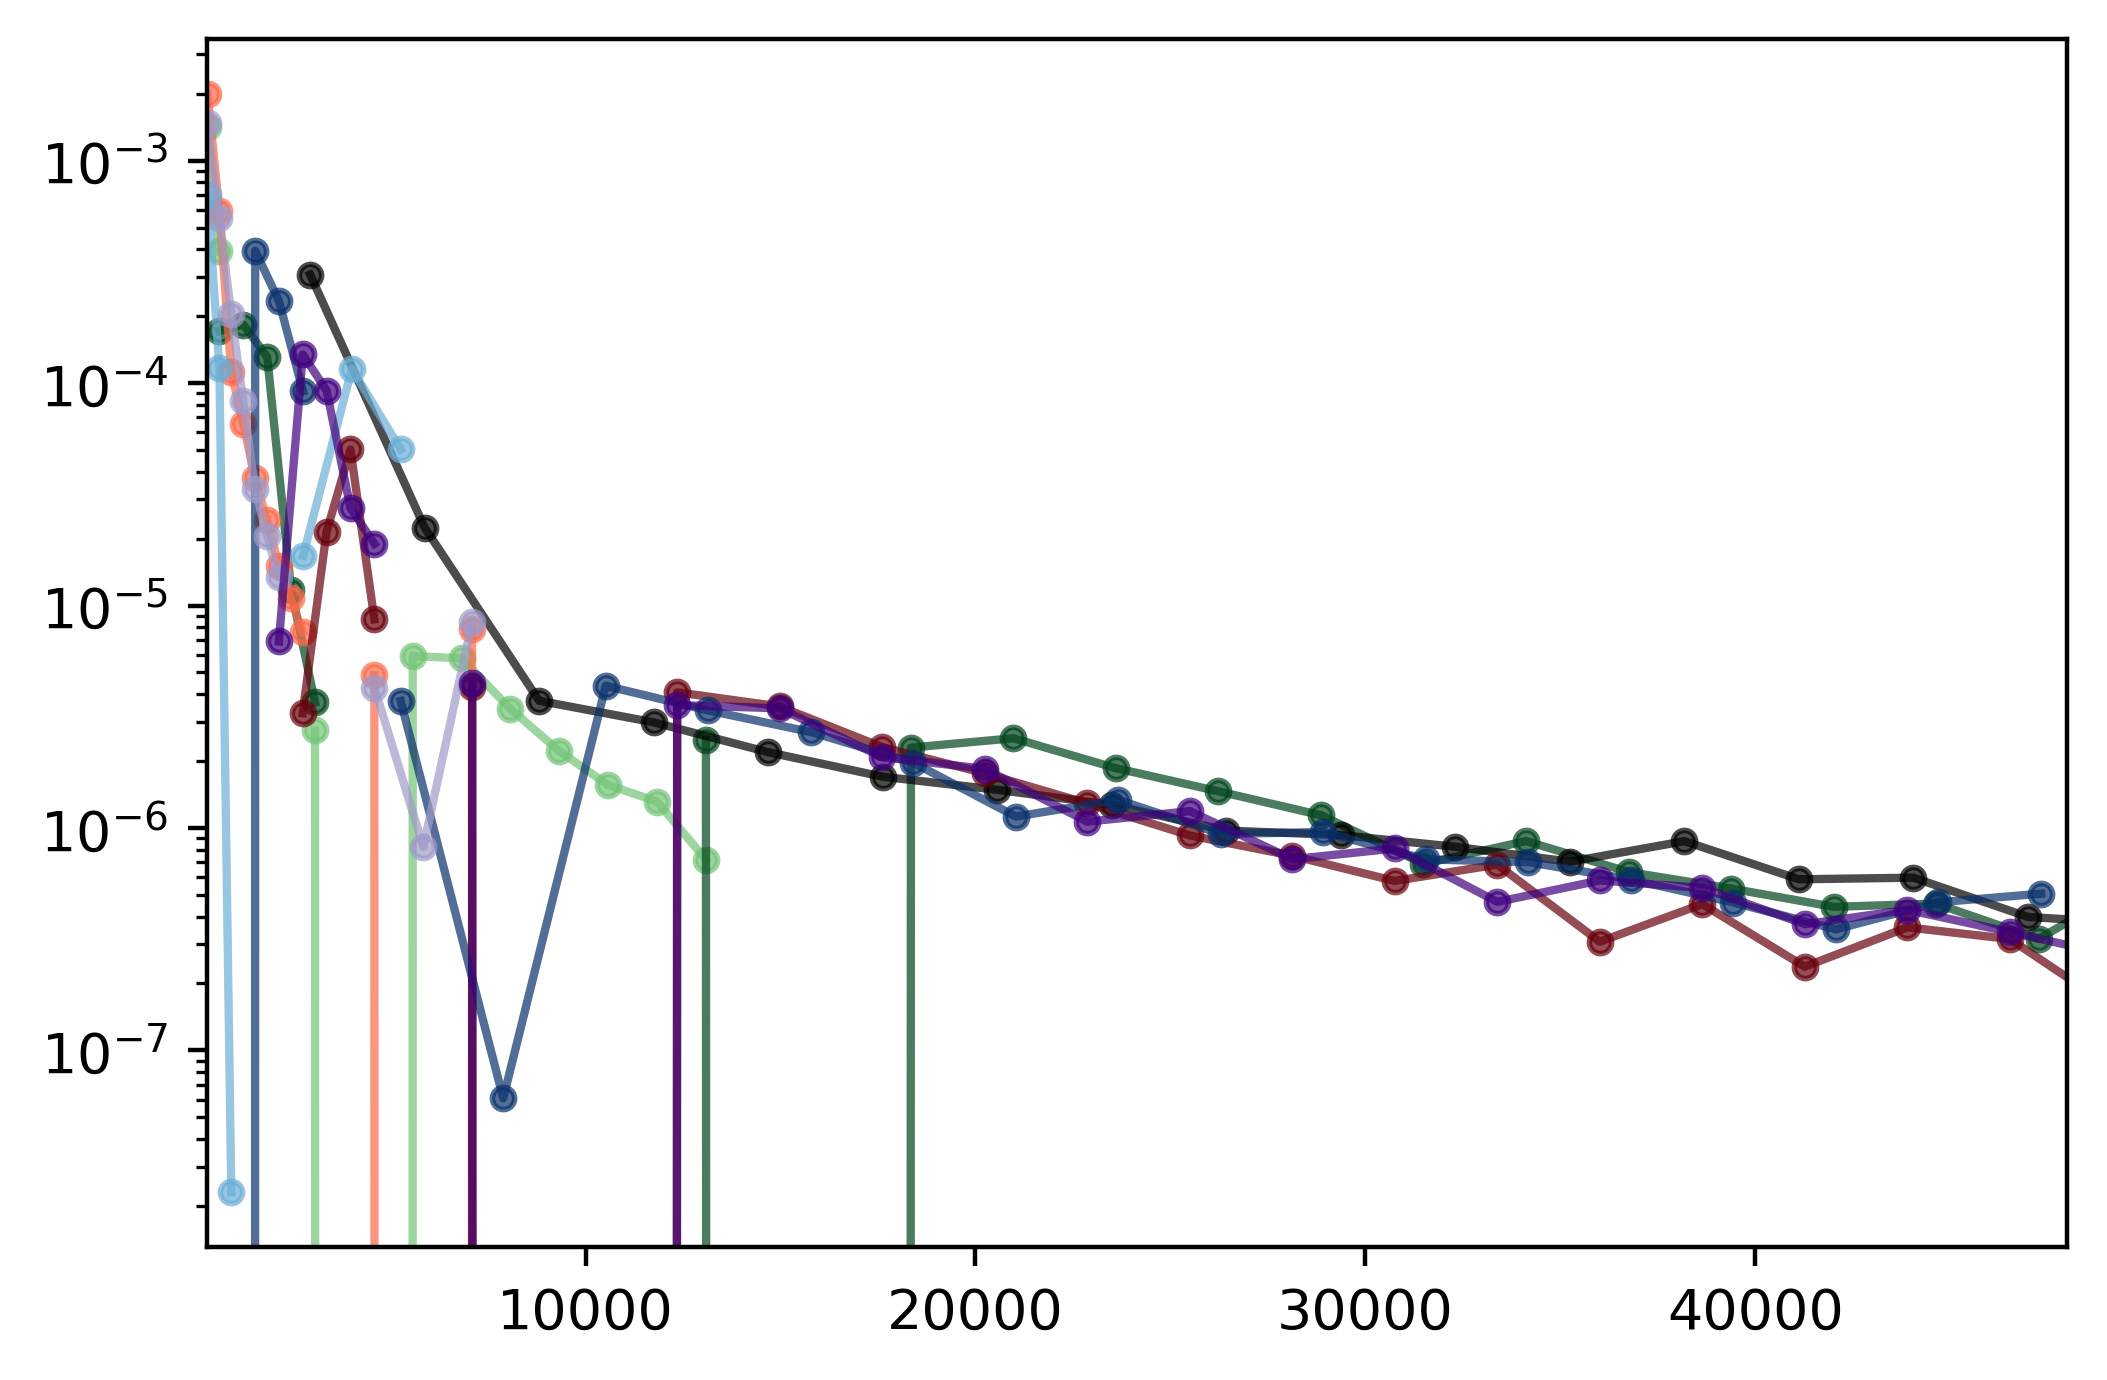

In [454]:
plt.figure(dpi=400)
# plot_delta_efficiency(configs, scaling_trace_0_01, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 3)))
# plot_delta_efficiency(configs, increasing_trace_4_0_1, colors = cm.get_cmap('Greens')(np.linspace(.5,1, 2)))

plot_delta_efficiency(configs, increasing_trace_0_1,
                      colors=cm.get_cmap('Greens')(np.linspace(.5, 1, 2)))
plot_delta_efficiency(full_configs, full_trace, colors=['black'])
# plot_delta_efficiency(configs, scaling_trace, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
# plot_delta_efficiency(configs, scaling_trace_0_2, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 3)))
# plot_delta_efficiency(configs, threshold_trace_t_0_1_s_0_2, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_1e5_s_0_1,
                      colors=cm.get_cmap('Reds')(np.linspace(.5, 1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_1e4_s_0_1,
                      colors=cm.get_cmap('Blues')(np.linspace(.5, 1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_2e5_s_0_1,
                      colors=cm.get_cmap('Purples')(np.linspace(.5, 1, 2)))

plt.yscale('log')
plt.xlim(300, 3e3 * 16)
# plt.xlim(100, 60e3)
# plt.ylim(.65, .72)

# plt.xscale('log')
plt.show()


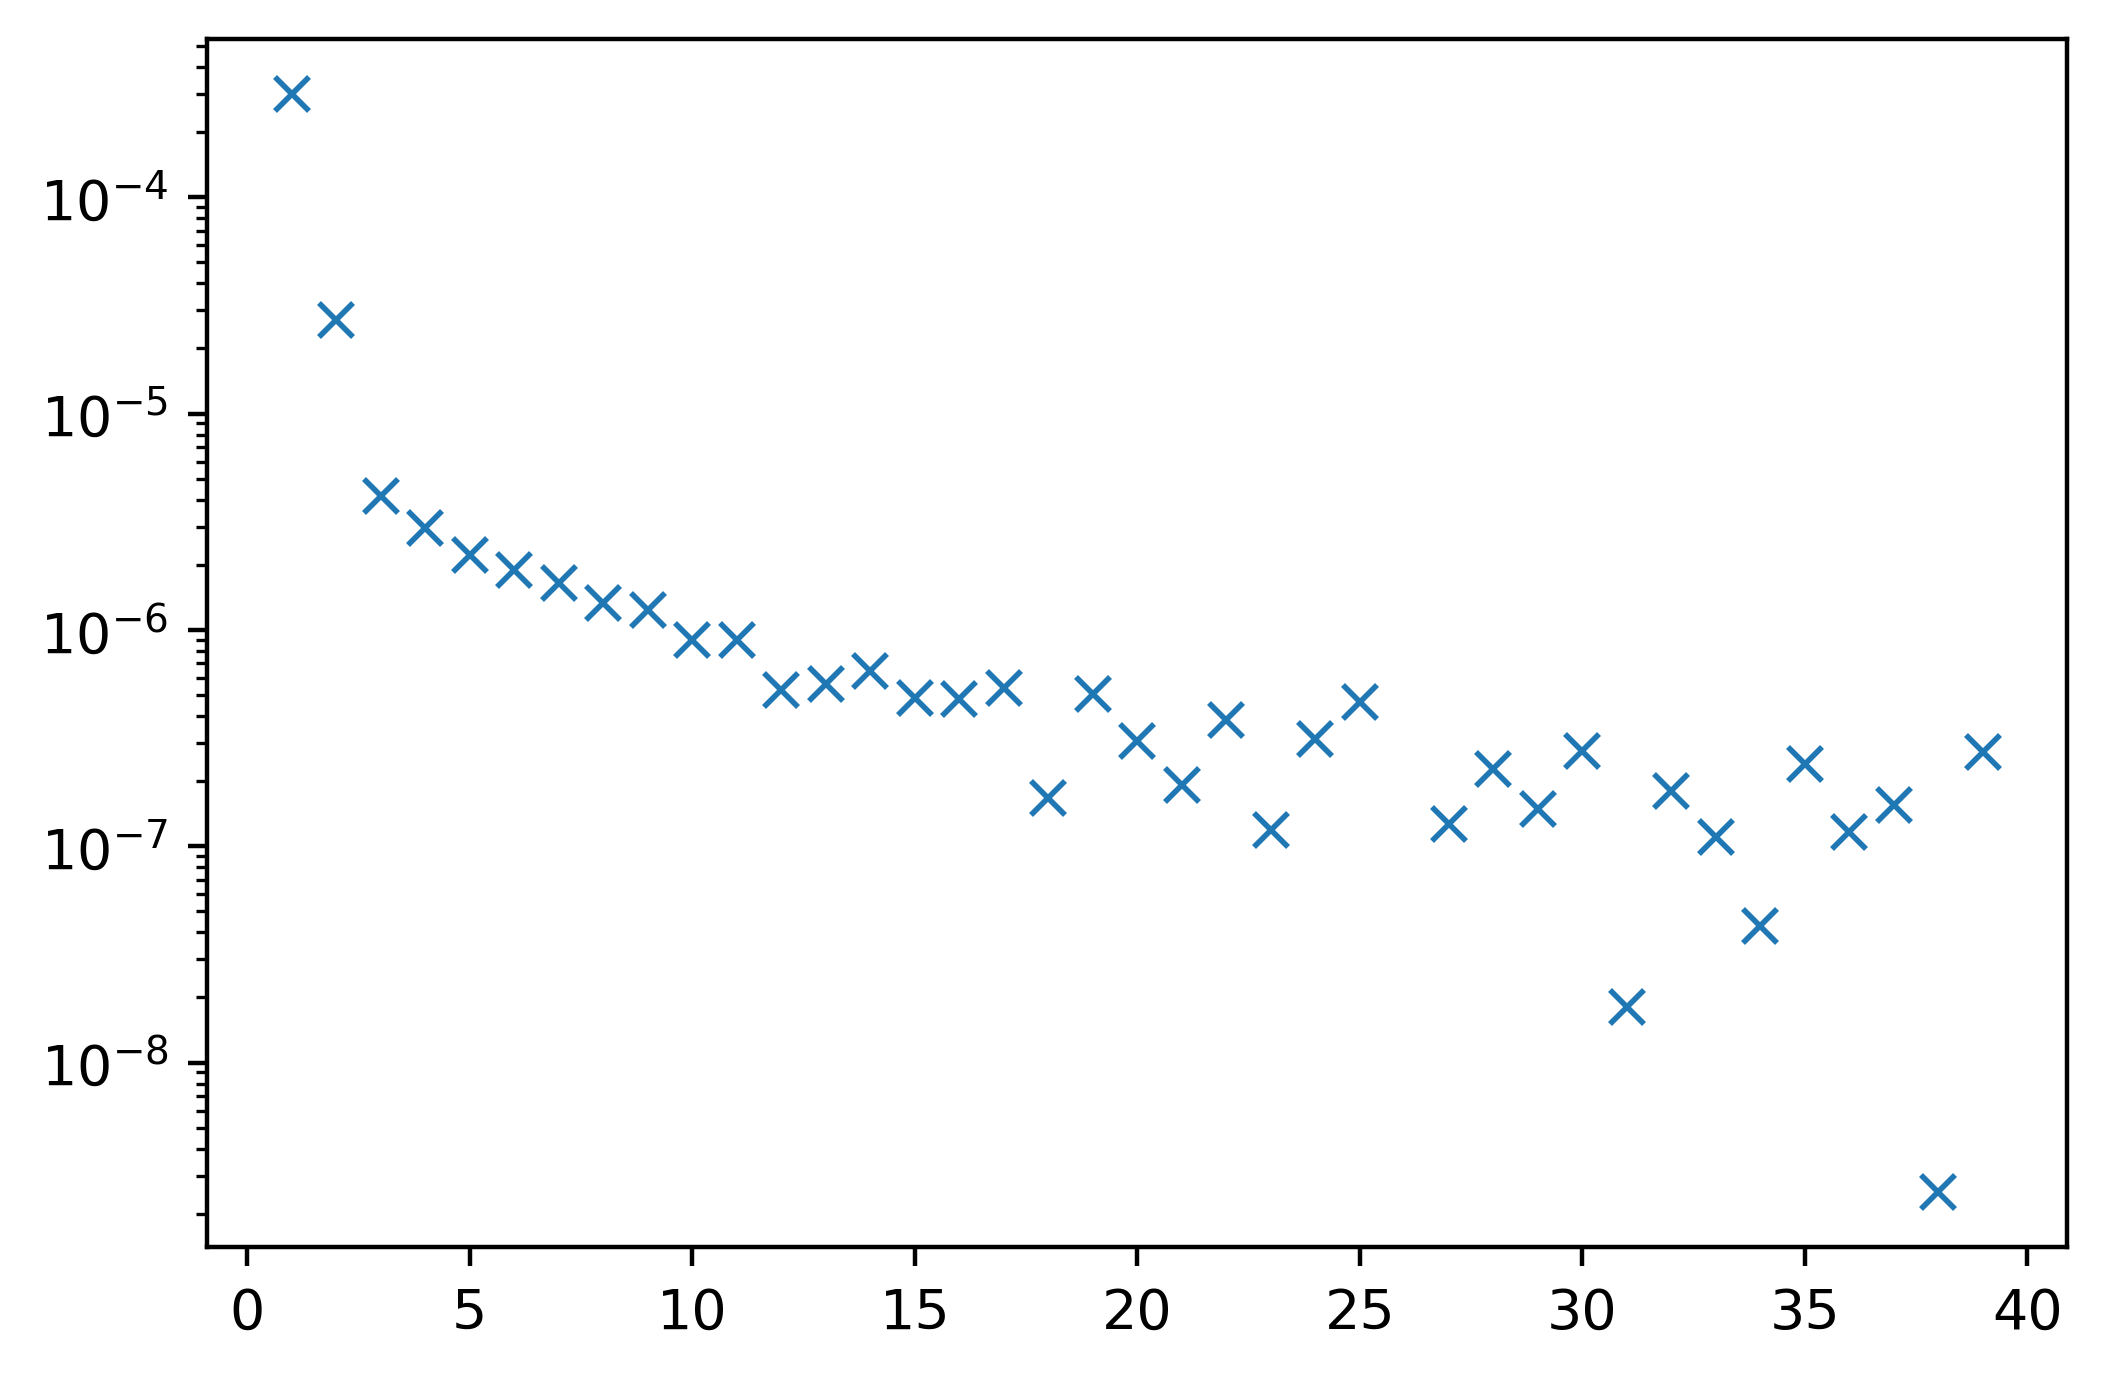

In [333]:
# plt.plot(-np.diff(full_trace['loss'], 1) / full_trace['size'][1:], full_trace['size'][1:])
# plt.plot(full_trace['epoch'][1:], -np.diff(full_trace['loss'], 1))
plt.figure(dpi=400)
plt.semilogy(full_trace['epoch'][1:], -
             np.diff(full_trace['loss'], 1) / full_trace['size'][1:], 'x')
